# Ex-fuzzy para la detección y disminución de sesgos - Ejemplo 3: Concesión de préstamos

Autores:


Raquel Fernandez Peralta - Slovak Academy of Sciences

Javier Fumanal Idocin - University of Essex, Yufe Fellow

En este ejemplo, utilizaremos un modelo basado en reglas borrosas para entrenar un algoritmo que decida si a una persona se le debe conceder un préstamo o no. Estudiaremos las reglas obtenidas por género y el sesgo de disparidad en las tasas de predicción positiva. Además, utilizaremos tres técnicas que se pueden utilizar para eliminar dicho sesgo y comentaremos el efecto que eso tiene en la base de reglas del clasificador.

## 1. Instalación e importación de paquetes

Primero de todo instalamos la librería ex-fuzzy y descargamos las bases de datos que vamos a utilizar en este tutorial.

In [ ]:
!pip install ex-fuzzy==2.1.3
!git clone https://github.com/Fuminides/WorkshopIgualdad2025.git
!pip install pandas numpy docutils scikit-learn matplotlib seaborn imblearn fairlearn lime

  Cloning https://github.com/Fuminides/ex-fuzzy.git to /tmp/pip-req-build-lkgfxymw
  Running command git clone --filter=blob:none --quiet https://github.com/Fuminides/ex-fuzzy.git /tmp/pip-req-build-lkgfxymw
  Resolved https://github.com/Fuminides/ex-fuzzy.git to commit 97baf4a1c6fa813481322d1fc8a60d075dfcf38a
  Preparing metadata (setup.py) ... done
fatal: destination path 'WorkshopIgualdad2025' already exists and is not an empty directory.


A continuación, importamos los demás paquetes de Python que vamos a utilizar en el tutorial.

In [2]:
import pandas as pd
import numpy as np
from docutils.nodes import legend
import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools
import ex_fuzzy.vis_rules as vis_rules
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from matplotlib.patches import Patch
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference,demographic_parity_ratio,equalized_odds_difference,equalized_odds_ratio,false_positive_rate,false_negative_rate,selection_rate,true_positive_rate,true_negative_rate
import ex_fuzzy.eval_rules as evr
import ex_fuzzy.rules as rules

## 2. Algunas funciones que nos van a ser útiles

Para simplificar el tutorial, hemos implementado algunas funciones básicas que simplificaran algunas ejecuciones más adelante.

In [3]:
def compute_metrics(y_test, y_pred, model_name="Model"):
    """
    Calcula y muestra métricas de evaluación de un modelo de clasificación,
    incluyendo una visualización de la matriz de confusión.

    Args:
        y_test: Valores reales
        y_pred: Predicciones del modelo
        model_name: Nombre del modelo para mostrar en los gráficos

    Returns:
        Diccionario con las métricas calculadas
    """
    # Calcular métricas
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Imprimir métricas con formato profesional
    print(f"\n=== {model_name} Evaluation Metrics ===")
    print(f"{'Accuracy:':<12} {metrics['Accuracy']:.4f}")
    print(f"{'F1 Score:':<12} {metrics['F1']:.4f}")
    print(f"{'Recall:':<12} {metrics['Recall']:.4f}")

    # Visualización de la matriz de confusión
    print("\n=== Confusion Matrix ===")

    # Configurar el estilo de seaborn
    sns.set(style="white")
    plt.figure(figsize=(5, 4))  # Reduced figure size from (8,6) to (5,4)

    # Crear heatmap de la matriz de confusión
    ax = sns.heatmap(metrics['Confusion Matrix'],
                     annot=True,
                     fmt="d",
                     cmap="Blues",
                     cbar=False,
                     annot_kws={"size": 12})  # Reduced annotation size from 14 to 12

    # Configuraciones adicionales del gráfico
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14, pad=15)  # Reduced font sizes
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size
    ax.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size

    plt.tight_layout()
    plt.show()

    return metrics

def calculate_fairness_metrics(y_true, y_pred, sensitive_features,
                             metrics=None, disparity_metrics=None):
    """
    Calcula y muestra métricas de equidad para un modelo de machine learning.

    Parámetros:
    -----------
    y_true : array-like
        Valores verdaderos (ground truth)
    y_pred : array-like
        Predicciones del modelo
    sensitive_features : array-like
        Características sensibles (género, raza, etc.) para evaluar equidad
    metrics : dict, opcional
        Diccionario de métricas por grupo. Si es None, usa las predeterminadas.
    disparity_metrics : dict, opcional
        Diccionario de métricas de disparidad. Si es None, usa las predeterminadas.

    Retorna:
    --------
    tuple: (fairness_frame, disparity_results)
        fairness_frame: Objeto MetricFrame con métricas por grupo
        disparity_results: Diccionario con métricas de disparidad
    """

    # Métricas predeterminadas si no se proporcionan
    if metrics is None:
        metrics = {
            "Selection Rate": selection_rate,
            "True Positive Rate": true_positive_rate,
            "False Positive Rate": false_positive_rate,
            "False Negative Rate": false_negative_rate,
            "True Negative Rate": true_negative_rate,
        }

    if disparity_metrics is None:
        disparity_metrics = {
            "Demographic Parity Difference": demographic_parity_difference,
            "Demographic Parity Ratio": demographic_parity_ratio,
            "Equalized Odds Difference": equalized_odds_difference,
            "Equalized Odds Ratio": equalized_odds_ratio,
        }

    # Calcular métricas por grupo
    fairness_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features,
    )

    # Calcular métricas de disparidad
    disparity_results = {
        name: metric(y_true, y_pred, sensitive_features=sensitive_features)
        for name, metric in disparity_metrics.items()
    }

    # Mostrar resultados
    print("\nDisparity Metrics (Lower is Fairer for Differences, Closer to 1 is Fairer for Ratios):")
    print(pd.Series(disparity_results).to_string())

    print("\nMetrics by Group:")
    print(fairness_frame.by_group)

    return fairness_frame, disparity_results

def generar_mascara_categorica(X, verbose=True):
    """
    Genera una máscara que indica el número de clases únicas para cada columna categórica.

    Parámetros:
    -----------
    X : pandas.DataFrame
        DataFrame de entrada a analizar
    verbose : bool, opcional
        Si True, imprime información sobre las clases únicas (por defecto True)

    Retorna:
    --------
    numpy.ndarray
        Array donde cada posición representa una columna del DataFrame:
        - 0 para columnas no categóricas
        - Número de clases únicas para columnas categóricas
    """
    # Verificar que el input sea un DataFrame usando la forma recomendada
    if not hasattr(X, 'columns') or not hasattr(X, 'dtypes'):
        raise TypeError("El argumento X debe ser un pandas DataFrame o similar")

    # Inicializar la máscara con ceros
    categorical_mask = np.zeros(X.shape[1], dtype=int)

    # Iterar sobre cada columna
    for i, column in enumerate(X.columns):
        # Verificar si la columna es categórica usando métodos actualizados
        col_dtype = X[column].dtype
        if is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype):
            # Obtener clases únicas (maneja valores nulos adecuadamente)
            unique_classes = X[column].dropna().unique()
            categorical_mask[i] = len(unique_classes)

            # Mostrar información si verbose=True
            if verbose:
                # Manejar correctamente tipos numéricos en categorías
                try:
                    sorted_classes = sorted(unique_classes.tolist())
                except TypeError:
                    sorted_classes = unique_classes.tolist()
                print(f"Columna '{column}' - Clases únicas ({len(unique_classes)}): {sorted_classes}")

    return categorical_mask

def extract_rules_from_text(str_rules):
    """
    Extracts rule parts from a formatted rules text.

    Args:
        str_rules (str): String containing rules separated by newlines,
                        with possible headers and separators.

    Returns:
        list: A collection of cleaned rule parts (before 'WITH' keyword).
    """
    rule_collection = []
    consequent = -1
    for rule_cand in str_rules.splitlines():
        rule_cand = rule_cand.strip()  # Clean whitespace
        if rule_cand.startswith('Rules for consequent'):
            consequent = consequent +1
        else:
            if not (rule_cand.startswith('Rules for consequent') or rule_cand.startswith('------')) and rule_cand:
                # Split at 'WITH' and take the part before it
                rule_part = rule_cand.split('WITH')[0].strip()
                if rule_part:  # Ensure it's not empty after splitting
                    rule_part = rule_part + ' THEN ' + str(consequent)
                    rule_collection.append(rule_part)
    return rule_collection

def plot_normalized_rule_firings_by_gender(results, rule_collection, figsize=(12, 10)):
    """
    Plots normalized rule firings by gender with additional information.

    Parameters:
    - results: DataFrame containing the data with 'Gender' and 'rule_selected' columns
    - rule_collection: List of rule descriptions
    - figsize: Tuple specifying figure size (width, height)
    """
    # Step 1: Count rule firings by gender and get total counts per gender
    rule_firing_counts = (
        results.groupby(['Gender', 'rule_selected'])
        .size()
        .reset_index(name='count')
    )

    # Get total counts per gender
    total_counts = results['Gender'].value_counts().to_dict()

    # Normalize the counts by total per gender
    rule_firing_counts['normalized_count'] = rule_firing_counts.apply(
        lambda row: row['count'] / total_counts[row['Gender']],
        axis=1
    )

    # Step 2: Set up gender mappings
    palette = {'Female': '#f4b942', 'Male': '#6a8d73'}
    gender_labels = {'Female': 'Female', 'Male': 'Male'}  # For consistency

    # Rule list
    rules = rule_collection
    rule_labels = [f'rule {i}' for i in range(len(rules))]

    # Step 3: Plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=rule_firing_counts,
        x='rule_selected',
        y='normalized_count',
        hue='Gender',
        palette=palette,
        hue_order=['Female', 'Male']  # Changed to string labels
    )
    plt.title('Normalized Rule Firings by Gender (proportion of group)')
    plt.xlabel('Rule')
    plt.ylabel('Proportion of Gender Group')

    # Step 4: Manually Create and Set Custom Legend
    legend_colors = {'Female': '#f4b942', 'Male': '#6a8d73'}
    handles = [
        Patch(
            color=legend_colors[gender],
            label=f"{gender_labels[gender]} (n={total_counts[gender]})"
        )
        for gender in ['Female', 'Male']  # Using actual gender strings
    ]
    plt.legend(title='Gender', handles=handles)

    # Add rule descriptions
    rule_text = '\n'.join([f"{label}: {rule}" for label, rule in zip(rule_labels, rules)])
    plt.figtext(
        0.5,  # x position (center)
        0.85,  # y position (just below plot)
        rule_text,
        ha='center',  # horizontal alignment
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray')
    )

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at bottom
    plt.show()

    return fig

## 3. Carga, exploracion y limpieza de los datos

Primero de todo, cargamos el dataset 'loan_approval.csv' que se puede encontrar en (https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset). El dataset contiene información histórica de solicitudes de préstamos, incluyendo datos demográficos, financieros y crediticios de los solicitantes, junto con la decisión de aprobación o rechazo de cada préstamo.

In [4]:
df = pd.read_csv('./WorkshopIgualdad2025/loan_approval.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Mostramos información general del dataset, como tipos de datos y valores no nulos.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Este dataset consta de las siguientes variables:

- **Loan_ID**: Identificador único del préstamo (ej. "LP001002").
- **Gender**: Género del solicitante (Male/Female).
- **Married**: Estado civil ("Yes" o "No").
- **Dependents**: Número de dependientes económicos (ej. "0", "1", "2", "3+").
- **Education**: Nivel educativo ("Graduate" o "Not Graduate").
- **Self_Employed**: Autoempleo ("Yes" o "No").
- **ApplicantIncome**: Ingreso mensual del solicitante (en moneda local).
- **CoapplicantIncome**: Ingreso mensual del co-solicitante (si aplica).
- **LoanAmount**: Cantidad solicitada del préstamo.
- **Loan_Amount_Term**: Plazo del préstamo en días (ej. 360 = ~12 meses).
- **Credit_History**: Historial crediticio.
- **Property_Area**: Ubicación de la propiedad ("Urban", "Rural", "Semiurban").
- **Loan_Status**: Variable objetivo ("Y" = aprobado, "N" = rechazado).

Mostramos estadísticas descriptivas de las columnas numéricas del dataset.

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


A continuación, hacemos un gráfico de barras que muestra la aprobación de préstamos por género.

<Figure size 800x600 with 0 Axes>

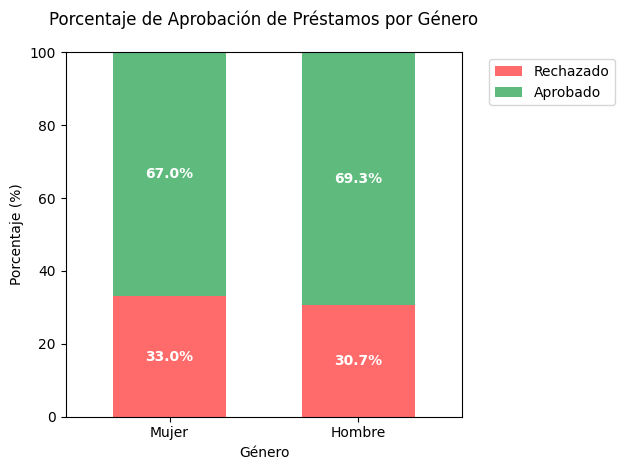

In [7]:
loan_pct = df.groupby(['Gender', 'Loan_Status']).size().unstack()
loan_pct = loan_pct.div(loan_pct.sum(axis=1), axis=0) * 100

# Crear el gráfico
plt.figure(figsize=(8, 6))
ax = loan_pct.plot(kind='bar',
                  stacked=True,
                  color=['#ff6b6b','#5fba7d'],
                  width=0.6)  # Controlar el ancho de las barras

plt.title('Porcentaje de Aprobación de Préstamos por Género', pad=20)
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)

# Mapeo de etiquetas
ax.set_xticklabels(['Mujer', 'Hombre'])
plt.legend(['Rechazado','Aprobado'], bbox_to_anchor=(1.05, 1))
plt.ylim(0, 100)

# Añadir etiquetas perfectamente centradas
for i, (gender, row) in enumerate(loan_pct.iterrows()):
    # Calcular alturas acumulativas
    bottom = 0
    for col in loan_pct.columns:
        value = row[col]
        if value > 0:  # Solo mostrar etiquetas para valores no cero
            # Posición vertical centrada en cada segmento
            label_y = bottom + value/2
            ax.text(i, label_y, f"{value:.1f}%",
                    ha='center', va='center',
                    color='white', fontweight='bold',
                    fontsize=10)
        bottom += value

plt.tight_layout()
plt.show()

Observamos si tenemos datos faltantes. A continuación, eliminamos las variables no significativas para clasificar y optamos por eliminar las filas que tengan algún dato faltante (también se podrían imputar https://scikit-learn.org/stable/modules/impute.html).

In [8]:
df2 = df.copy()

In [9]:
missing_values = df2.isnull().sum()
print(missing_values[missing_values > 0])

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64


In [10]:
df2 = df2.dropna()

In [11]:
X = df2.drop(columns=['Loan_Status','Loan_ID'])
y = df2['Loan_Status'].map({'N': 0, 'Y': 1}).to_numpy()

Asignamos a cada variable el tipo que le corresponde. Este paso es necesario para una correcta codificación de las variables categóricas.

In [12]:
X.dtypes

,0
Gender,object
Married,object
Dependents,object
Education,object
Self_Employed,object
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64
Credit_History,float64


Finalmente, hacemos un histograma para ver el % de cada género en la muestra.

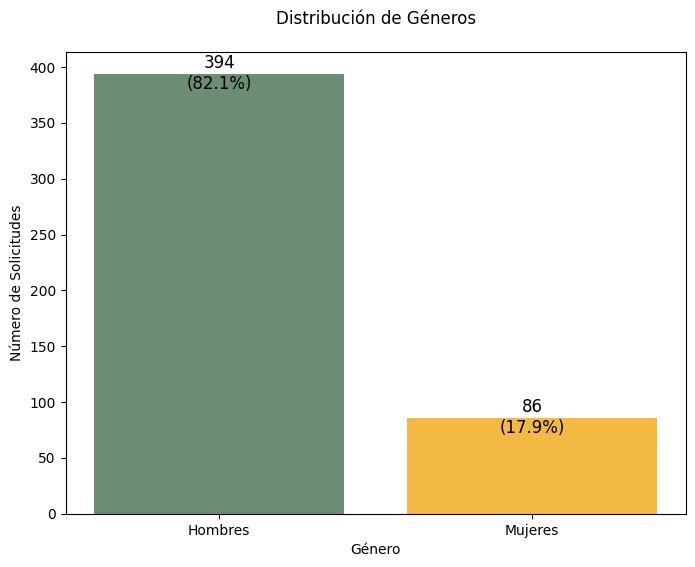

In [13]:
# Calcular conteos y porcentajes
gender_counts = df2['Gender'].value_counts()
gender_percent = gender_counts / gender_counts.sum() * 100

# Mapear los valores de género a etiquetas (si es necesario)
labels = {'Female': 'Mujeres', 'Male': 'Hombres'}  # Ajusta según tus categorías
gender_counts.index = gender_counts.index.map(labels)
gender_percent.index = gender_percent.index.map(labels)

colors = ['#6a8d73', '#f4b942']  # Verde tierra y amarillo mostaza

# Crear el gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors)


plt.title('Distribución de Géneros', pad=20)
plt.xlabel('Género')
plt.ylabel('Número de Solicitudes')

# Añadir etiquetas combinadas (conteo + porcentaje)
for bar, count, percent in zip(bars, gender_counts.values, gender_percent.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({percent:.1f}%)',
             ha='center', va='center', fontsize=12, color='black')

plt.show()

## 4. Entrenamos un clasificador basado en reglas con ex-fuzzy

Primero de todo, separamos la base de datos en conjunto de entrenamiento y validación. En este caso, guardamos también la distribución de géneros en cada muestra.

In [14]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, X['Gender'],test_size=0.33, random_state=42)

Para este ejemplo, fijamos el siguiente número de iteraciones y tamaño de la población para todos los clasificadores considerados.

In [15]:
n_gen = 100
pop_size = 50

Creamos un vector que nos indique qué variables son categóricas y cuántas clases tiene dicha variable.

In [16]:
categorical_mask = generar_mascara_categorica(X,verbose=True)

Columna 'Gender' - Clases únicas (2): ['Female', 'Male']
Columna 'Married' - Clases únicas (2): ['No', 'Yes']
Columna 'Dependents' - Clases únicas (4): ['0', '1', '2', '3+']
Columna 'Education' - Clases únicas (2): ['Graduate', 'Not Graduate']
Columna 'Self_Employed' - Clases únicas (2): ['No', 'Yes']
Columna 'Property_Area' - Clases únicas (3): ['Rural', 'Semiurban', 'Urban']


Entrenamos el clasficador basado en reglas borrosas.

In [17]:
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fs.FUZZY_SETS.t1, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.001, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=3, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = False, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask = categorical_mask, # Máscara de variables categóricas.
                                           ds_mode=2, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )
fl_classifier.fit(X_train,
                  y_train,
                  n_gen=n_gen, # Número de iteraciones
                  pop_size=pop_size, # Número de individuos a considerar en cada iteración
                  random_state=42)

Si damos un vistazo a las reglas obtenidas, podemos ver como en este ejemplo la única regla vinculada a dar un préstamo tiene la condición de que el género del individuo sea masculino. Por lo tanto, sin ir más allá podemos ver que el clasificador está claramente sesgado.

In [18]:
rule_base = fl_classifier.get_rulebase()
fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.7507788161993769
Test performance: 0.7295597484276729
------------
MATTHEW CORRCOEF
Train performance: 0.438298253686422
Test performance: 0.3008517172397995
------------
Rules for consequent: 0
----------------
IF Married IS Yes AND Self_Employed IS No AND ApplicantIncome IS Medium WITH DS 0.001214271842439782, ACC 0.6511627906976745, WGHT 0.93
IF Married IS No WITH DS 0.044108655777797184, ACC 0.5081967213114754, WGHT 0.52
IF Self_Employed IS Yes AND CoapplicantIncome IS Low WITH DS 0.005260232880600926, ACC 1.0, WGHT 0.9

Rules for consequent: 1
----------------
IF Gender IS Male AND Credit_History IS High WITH DS 0.37363767820576277, ACC 0.8333333333333334, WGHT 0.9


Si hacemos el histograma del % de pacientes asignados a cada regla por género podemos ver aún de manera más clara el sesgo del algoritmo.

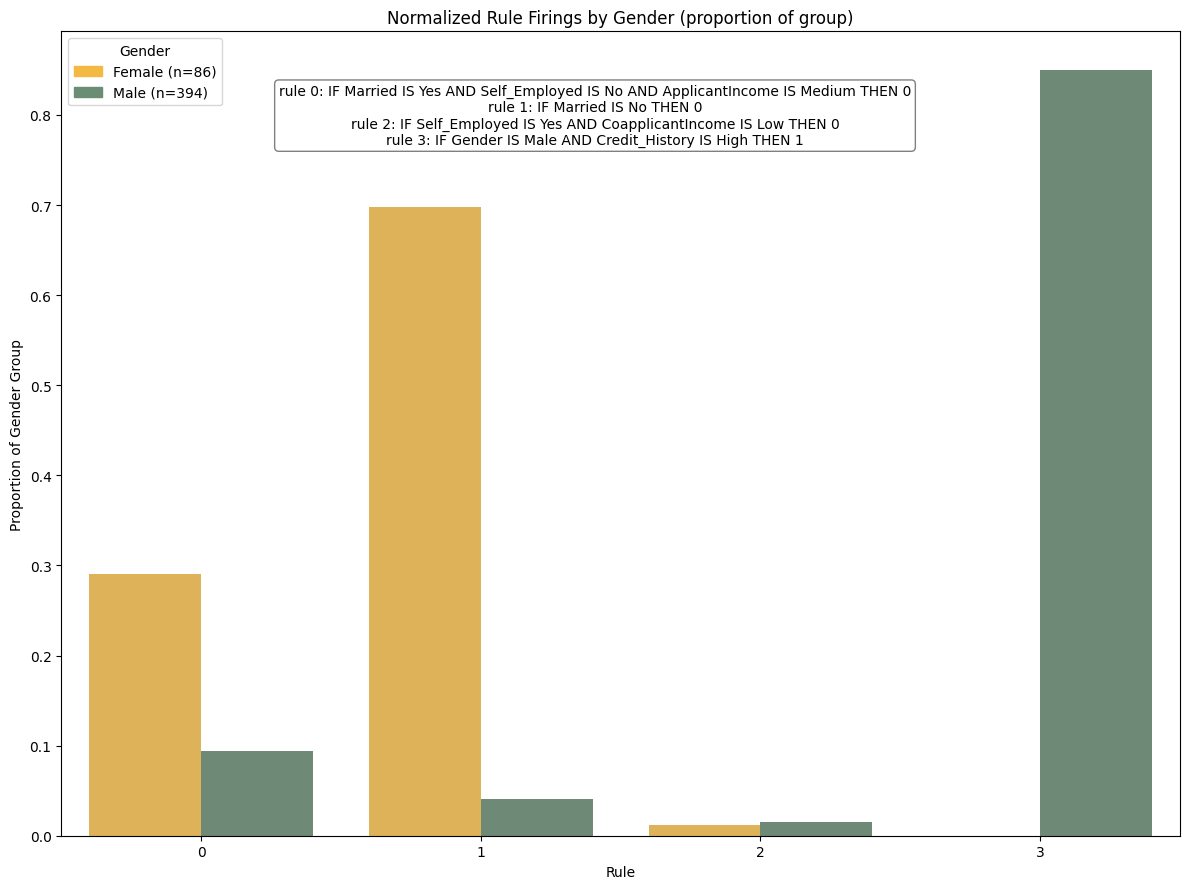

In [19]:
explainable_predict = fl_classifier.explainable_predict(X)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]
rule_collection = extract_rules_from_text(str_rules)
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X)
n_rules = rule_memberships.shape[1]  # Automatically detect number of rules

# Create a dictionary for the DataFrame
data = {
    'Gender': X['Gender'].values.ravel(),
    'rule_selected': np.array(fired_rules).ravel()  # Selected rule indices
}

# Add rule membership columns dynamically
for rule_idx in range(n_rules):
    data[f'rule {rule_idx}'] = rule_memberships[:, rule_idx].ravel()

# Create DataFrame
results = pd.DataFrame(data)
fig = plot_normalized_rule_firings_by_gender(results, rule_collection, figsize=(12, 10))

Aunque el algoritmo esté sesgado por género, podemos ver que presenta una buena precisión con respecto a las medidas consideradas.


=== Model Evaluation Metrics ===
Accuracy:    0.7296
F1 Score:    0.8186
Recall:      0.8661

=== Confusion Matrix ===


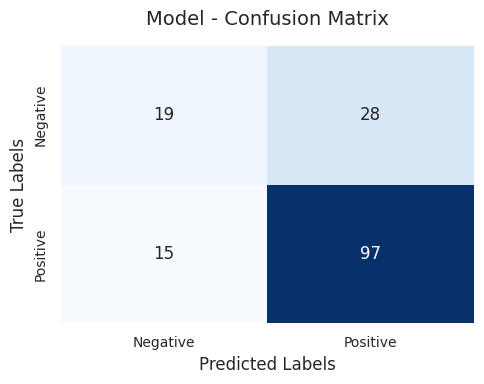

In [20]:
y_pred = fl_evaluator.fl_classifier.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

Aunque el algoritmo tenga una buena precisión global, claramente la precisión por género es muy mala.

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'mcc'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>]], dtype=object)

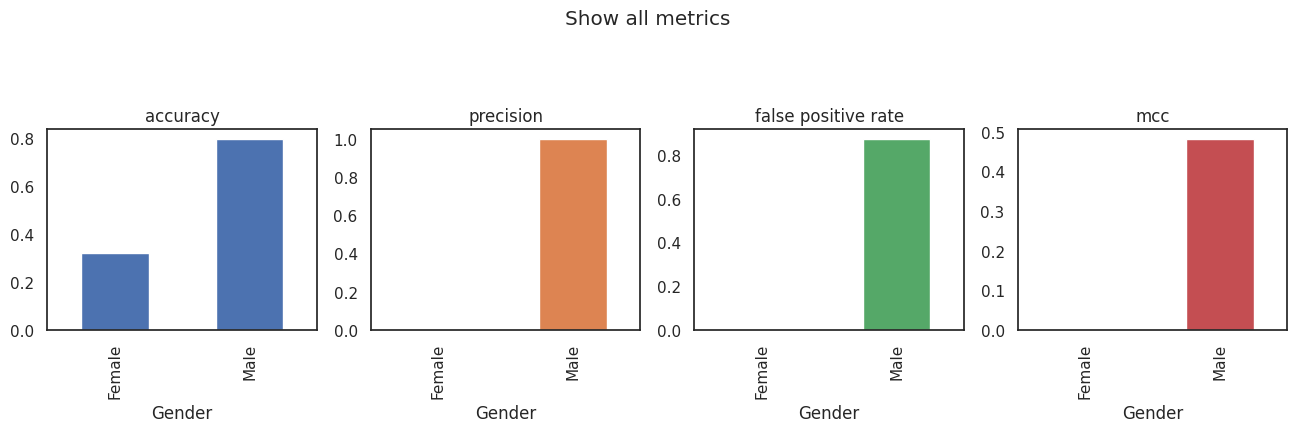

In [21]:
metrics = {"accuracy": accuracy_score,"precision": recall_score,"false positive rate": f1_score,"mcc": matthews_corrcoef}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[4, 4],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)

En este ejemplo, a parte de considerar la disparidad en la precisión utilizamos métricas específicas para lidiar con el tipo de sesgo vinculado con el problema en cuestión.

Dada una muestra, se llama **tasa de selección** a la proporción de predicciones positivas en un grupo. En este caso, la proporción de prestamos concedidos.

$$
SR = \frac{TP + FP}{TP + FP + TN + FN}
$$

Es intuitivo pensar que en este contexto sería justo que ambos géneros tuviesen una proporción de prestamos concedidos parecido. Para cuantificar esto podemos considerar la Demographic Parity Difference (DPD) o la Demographic Parity Ratio (DPR):

- **Demographic Parity Difference (DPD)**: Diferencia absoluta entre las tasas de selección (Selection Rate, SR) del grupo con mayor beneficio y el grupo con menor beneficio.

$$
DPD = \max(SR_{\text{grupo}}) - \min(SR_{\text{grupo}})
$$
- **Demographic Parity Ratio (DPR)**: Razón entre la tasa de selección del grupo perjudicado y la del grupo favorecido.
$$
DPR = \frac{\min(SR_{\text{grupo}})}{\max(SR_{\text{grupo}})}
$$

Existen muchas otras métricas que se pueden considerar (https://fairlearn.org/main/user_guide/assessment/common_fairness_metrics.html) pero en este ejemplo nos centraremos en quantificar estas dos.

Si calculamos dichas métricas, podemos quantificar quan sesgado está nuestro clasificador.

In [22]:
fairness_results, disparity_results = calculate_fairness_metrics(y_true=y_test,y_pred=y_pred,sensitive_features=A_test)


Disparity Metrics (Lower is Fairer for Differences, Closer to 1 is Fairer for Ratios):
Demographic Parity Difference    0.912409
Demographic Parity Ratio         0.000000
Equalized Odds Difference        1.000000
Equalized Odds Ratio             0.000000

Metrics by Group:
        Selection Rate  True Positive Rate  False Positive Rate  \
Gender                                                            
Female        0.000000                 0.0                  0.0   
Male          0.912409                 1.0                  0.7   

        False Negative Rate  True Negative Rate  
Gender                                           
Female                  1.0                 1.0  
Male                    0.0                 0.3  


## 5. Mitigación de sesgo

En esta sección vemos como podemos utilizar 3 técnicas para mitigación de sesgos conjuntamente con *ex-fuzzy* para controlar el sesgo detectado en la sección anterior.

### 5.1 Equidad mediante la ignorancia (Fairness through unawareness)

Primero de todo, consideramos técnica naive de mitigación de sesgo que consiste en eliminar las variables sensibles (género) del conjunto de datos antes de entrenar el modelo, bajo el supuesto de que, al no "ver" estos atributos, el modelo no podrá discriminarlos.

Eliminamos la variable *genero* del conjunto de entrenamiento y validación.

In [23]:
X_train_nogender = X_train.drop(columns=['Gender'])
X_test_nogender = X_test.drop(columns=['Gender'])
X_nogender = X.drop(columns=['Gender'])

Entrenamos el clasificador.

In [24]:
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fs.FUZZY_SETS.t1, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.0001, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=3, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = False, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask =  generar_mascara_categorica(X_train_nogender,verbose=False), # Máscara de variables categóricas.
                                           ds_mode=2, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )
fl_classifier.fit(X_train_nogender,
                  y_train,
                  n_gen=n_gen, # Número de iteraciones
                  pop_size=pop_size, # Número de individuos a considerar en cada iteración
                  random_state=42)

Observamos la base de reglas obtenida. En este caso podemos ver que a simple vista ya no se puede detectar un sesgo por género.

In [25]:
rule_base = fl_classifier.get_rulebase()
fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train_nogender, y_train, X_test_nogender, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.822429906542056
Test performance: 0.7987421383647799
------------
MATTHEW CORRCOEF
Train performance: 0.568592292199479
Test performance: 0.48370415307697145
------------
Rules for consequent: 0
----------------
IF CoapplicantIncome IS High WITH DS 0.0009801923506177154, ACC 0.8412698412698413, WGHT 0.41
IF Dependents IS 0 AND Self_Employed IS Yes AND Property_Area IS Semiurban WITH DS 0.0029405770518531457, ACC 1.0, WGHT 0.06

Rules for consequent: 1
----------------
IF Loan_Amount_Term IS Medium AND Credit_History IS High WITH DS 0.2405666500775781, ACC 0.81640625, WGHT 0.29
IF Married IS No AND Education IS Graduate AND Loan_Amount_Term IS Low WITH DS 0.0016651916381150377, ACC 1.0, WGHT 0.62


Además, la precisión del algoritmo ha augmentado considerablemente.


=== Model Evaluation Metrics ===
Accuracy:    0.7987
F1 Score:    0.8730
Recall:      0.9821

=== Confusion Matrix ===


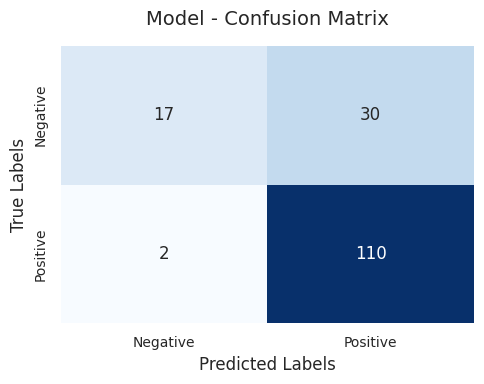

In [26]:
y_pred = fl_evaluator.fl_classifier.predict(X_test_nogender)
metrics = compute_metrics(y_test, y_pred)

La precisión por género también se ha balanceado.

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'mcc'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>]], dtype=object)

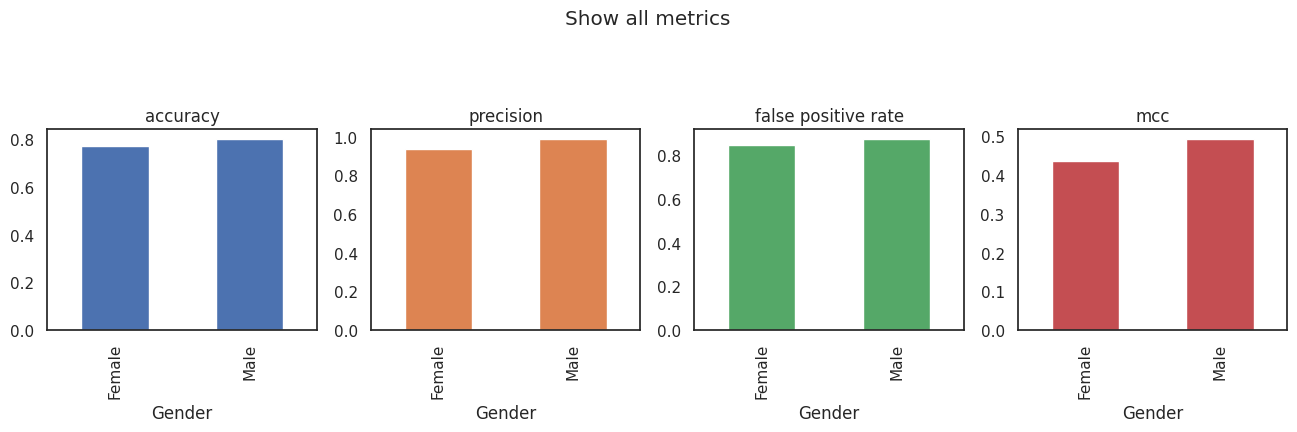

In [27]:
metrics = {"accuracy": accuracy_score,"precision": recall_score,"false positive rate": f1_score,"mcc": matthews_corrcoef}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[4, 4],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)

También podemos ver un cambio drástico en la DPD y el DPR.

In [28]:
fairness_results, disparity_results = calculate_fairness_metrics(y_true=y_test,y_pred=y_pred,sensitive_features=A_test)


Disparity Metrics (Lower is Fairer for Differences, Closer to 1 is Fairer for Ratios):
Demographic Parity Difference    0.072329
Demographic Parity Ratio         0.918778
Equalized Odds Difference        0.078571
Equalized Odds Ratio             0.879121

Metrics by Group:
        Selection Rate  True Positive Rate  False Positive Rate  \
Gender                                                            
Female        0.818182            0.933333             0.571429   
Male          0.890511            0.989691             0.650000   

        False Negative Rate  True Negative Rate  
Gender                                           
Female             0.066667            0.428571  
Male               0.010309            0.350000  


Finalmente, si observamos el histograma de las reglas utilizadas por género podemos ver como ahora la clasificación es mucho más homogénea.

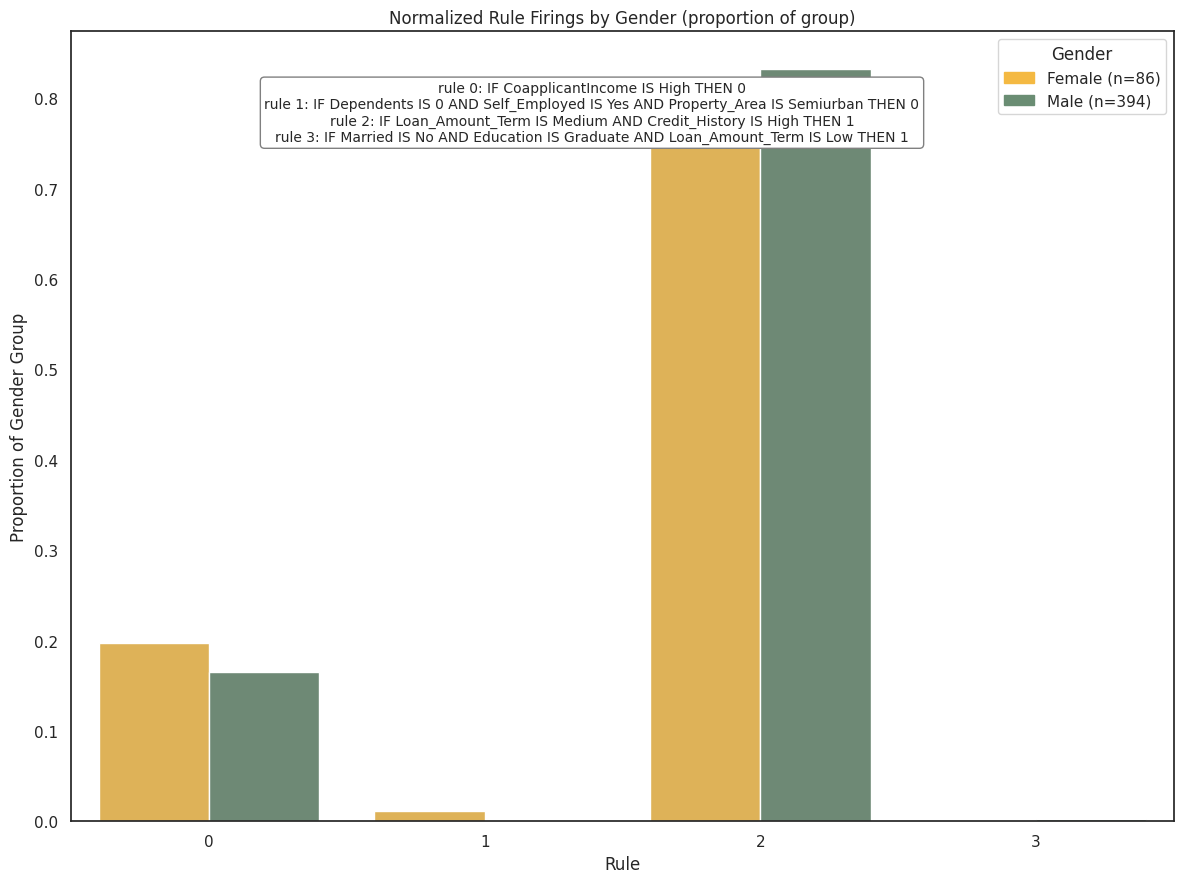

In [29]:
explainable_predict = fl_classifier.explainable_predict(X_nogender)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]
rule_collection = extract_rules_from_text(str_rules)
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X_nogender)
n_rules = rule_memberships.shape[1]  # Automatically detect number of rules

# Create a dictionary for the DataFrame
data = {
    'Gender': X['Gender'].values.ravel(),
    'rule_selected': np.array(fired_rules).ravel()  # Selected rule indices
}

# Add rule membership columns dynamically
for rule_idx in range(n_rules):
    data[f'rule {rule_idx}'] = rule_memberships[:, rule_idx].ravel()

# Create DataFrame
results = pd.DataFrame(data)
fig = plot_normalized_rule_firings_by_gender(results, rule_collection, figsize=(12, 10))



### 5.2 Equidad mediante ponderación en el preprocesamiento (Fairness through preprocessing weightin)

Aunque la técnica de eliminar la variable *género* ha sido efectiva en este caso particular, según el contexto esto podría no ser posible o podrían existir otras variables que estuviesen altamente correlacionadas con el género que generasen el mismo efecto aún eliminando la variable sensible. Por eso, existen muchas otras técnicas de reducción de sesgo (https://fairlearn.org/v0.8/user_guide/mitigation.html). Entre ellas, existe la posibilidad de asignar un peso a cada individuo, ya sea como preprocesamiento o de manera iterativa durante el entrenamiento. Aunque hay muchas formas de llevar a cabo este paso, en este ejemplo optamos por definir unos pesos sencillos que asignan mayor peso a subgrupos subrepresentados para compensar desequilibrios.

Concretamente, utilizamos el mismo procedimiento que en [1] y a cada ejemplo le asignamos un peso de acuerdo al género y la concesión o no del préstamo con el objetivo de balancear la distribución de clases (favorables/no favorables) entre grupos. A cada individuo del grupo $(g,y)$ (género $g$ y etiqueta $y$) se le asigna el peso

$$
w_{g,y} = \frac{N_y \cdot N_g}{N \cdot n_{g,y}}
$$

donde

- $N$: Total de individuos.
-  $N_y$: Total de individuos con etiqueta $y$.
- $N_g$: Total de individuos en el grupo $g$.
- $n_{g,y}$: Total de individuos en el grupo $g$ con etiqueta $y$.

In [30]:
gender = X_train['Gender']

In [31]:
# Create DataFrame
df = pd.DataFrame({'y_train': y_train, 'gender': gender})
# Compute counts
total_samples = len(df)
total_favorable = df['y_train'].sum()
total_unfavorable = total_samples - total_favorable
total_men = (df['gender'] == 'Male').sum()
total_women = total_samples - total_men

# Group counts
group_counts = df.groupby(['gender', 'y_train']).size().unstack(fill_value=0)

# Compute weights for each subgroup
weights = {}
for g in ['Male', 'Female']:
    for y in [0, 1]:
        subgroup_count = group_counts.loc[g, y]
        if subgroup_count == 0:
            weights[(g, y)] = 0  # Avoid division by zero
        else:
            if y == 1:  # Favorable
                weights[(g, y)] = (total_favorable * (total_men if g == 'Male' else total_women)) / (total_samples * subgroup_count)
            else:  # Unfavorable
                weights[(g, y)] = (total_unfavorable * (total_men if g == 'Male' else total_women)) / (total_samples * subgroup_count)

print("\nWeights per subgroup:", weights)

# Assign weights to each person
df['weight'] = df.apply(lambda row: weights[(row['gender'], row['y_train'])], axis=1)

print("\nDataFrame with weights:")
print(df)


Weights per subgroup: {('Male', 0): np.float64(1.0639858993277587), ('Male', 1): np.float64(0.9731329925474604), ('Female', 0): np.float64(0.8054828660436137), ('Female', 1): np.float64(1.124690470484863)}

DataFrame with weights:
     y_train gender    weight
153        0   Male  1.063986
149        1   Male  0.973133
342        1   Male  0.973133
546        0   Male  1.063986
185        1   Male  0.973133
..       ...    ...       ...
141        1   Male  0.973133
350        1   Male  0.973133
445        1   Male  0.973133
558        1   Male  0.973133
137        1   Male  0.973133

[321 rows x 3 columns]


Ahora, podemos utilizar la modificación del Matthews correlation coefficient con respecto a estos pesos para definir una nueva función de pérdida a la hora de entrenar el clasficador.

In [32]:
def new_loss(ruleBase: rules.RuleBase, X:np.array, y:np.array, tolerance:float, alpha:float=0.99, beta:float=0.0125, gamma:float=0.0125, precomputed_truth=None) -> float:
        ev_object = evr.evalRuleBase(ruleBase, X, y, precomputed_truth=precomputed_truth)
        ev_object.add_rule_weights()
        preds = ev_object.mrule_base.winning_rule_predict(ev_object.X, precomputed_truth=ev_object.precomputed_truth)
        score_acc = matthews_corrcoef(y, preds, sample_weight=df['weight'].values)
        return score_acc

categorical_mask = generar_mascara_categorica(X_train,verbose=False)
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fs.FUZZY_SETS.t1, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.0, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=3, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = False, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask = categorical_mask, # Máscara de variables categóricas.
                                           ds_mode=2, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )

fl_classifier.customized_loss(new_loss)

fl_classifier.fit(X_train,
                  y_train,
                  n_gen=n_gen, # Número de iteraciones
                  pop_size=pop_size, # Número de individuos a considerar en cada iteración
                  random_state=42)

rule_base = fl_classifier.get_rulebase()

fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.7507788161993769
Test performance: 0.7295597484276729
------------
MATTHEW CORRCOEF
Train performance: 0.4451422065455395
Test performance: 0.3008517172397995
------------
Rules for consequent: 0
----------------
IF Dependents IS 3+ AND Education IS Graduate AND CoapplicantIncome IS Medium WITH DS 0.0009801923506177154, ACC 0.56, WGHT 0.79
IF Gender IS Male AND Dependents IS 0 AND Credit_History IS High WITH DS 0.021564231713589736, ACC 0.75, WGHT 0.14
IF Loan_Amount_Term IS Medium WITH DS 0.008009019978566909, ACC 0.8, WGHT 0.23
IF Married IS Yes AND Self_Employed IS Yes AND CoapplicantIncome IS Medium WITH DS 0.00046246254800604545, ACC 1.0, WGHT 0.21

Rules for consequent: 1
----------------
IF Gender IS Male AND ApplicantIncome IS Low AND Credit_History IS High WITH DS 0.32386383613565023, ACC 0.8398058252427184, WGHT 0.79



=== Model Evaluation Metrics ===
Accuracy:    0.7296
F1 Score:    0.8186
Recall:      0.8661

=== Confusion Matrix ===


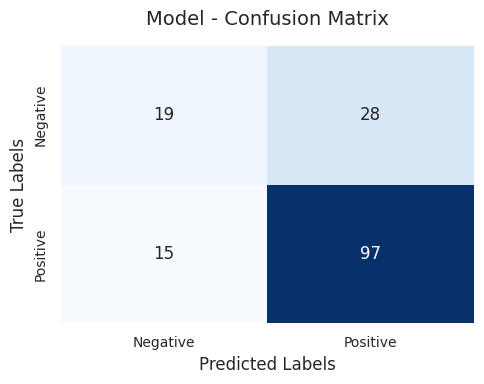

In [33]:
y_pred = fl_evaluator.fl_classifier.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

De manera similar a la sección anterior, debemos hacer los cálculos pertinentes para estudiar si el algoritmo está sesgado. En este caso, claramente el sesgo no se ha controlado.

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'mcc'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>]], dtype=object)

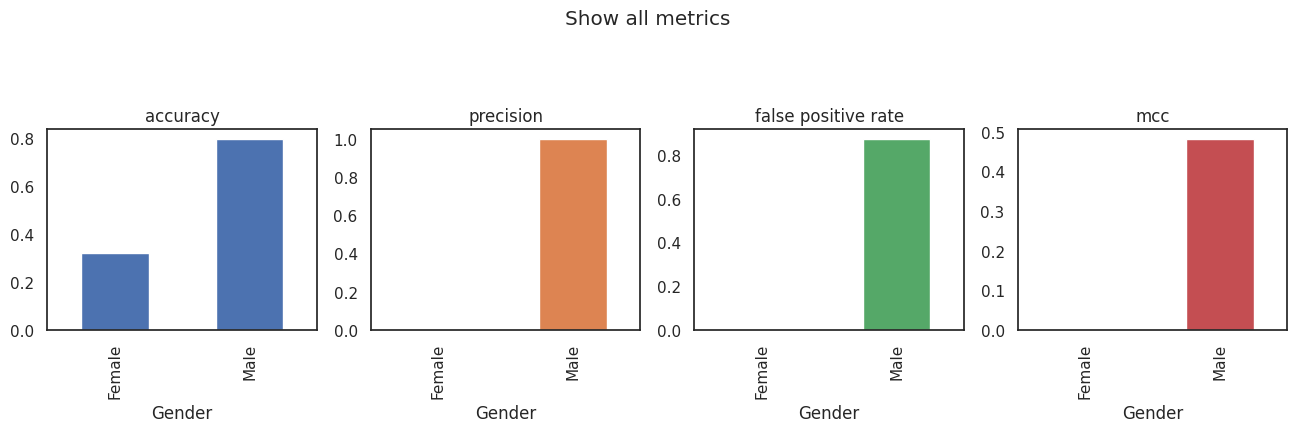

In [34]:
metrics = {"accuracy": accuracy_score,"precision": recall_score,"false positive rate": f1_score,"mcc": matthews_corrcoef}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[4, 4],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)

In [35]:
fairness_results, disparity_results = calculate_fairness_metrics(y_true=y_test,y_pred=y_pred,sensitive_features=A_test)


Disparity Metrics (Lower is Fairer for Differences, Closer to 1 is Fairer for Ratios):
Demographic Parity Difference    0.912409
Demographic Parity Ratio         0.000000
Equalized Odds Difference        1.000000
Equalized Odds Ratio             0.000000

Metrics by Group:
        Selection Rate  True Positive Rate  False Positive Rate  \
Gender                                                            
Female        0.000000                 0.0                  0.0   
Male          0.912409                 1.0                  0.7   

        False Negative Rate  True Negative Rate  
Gender                                           
Female                  1.0                 1.0  
Male                    0.0                 0.3  


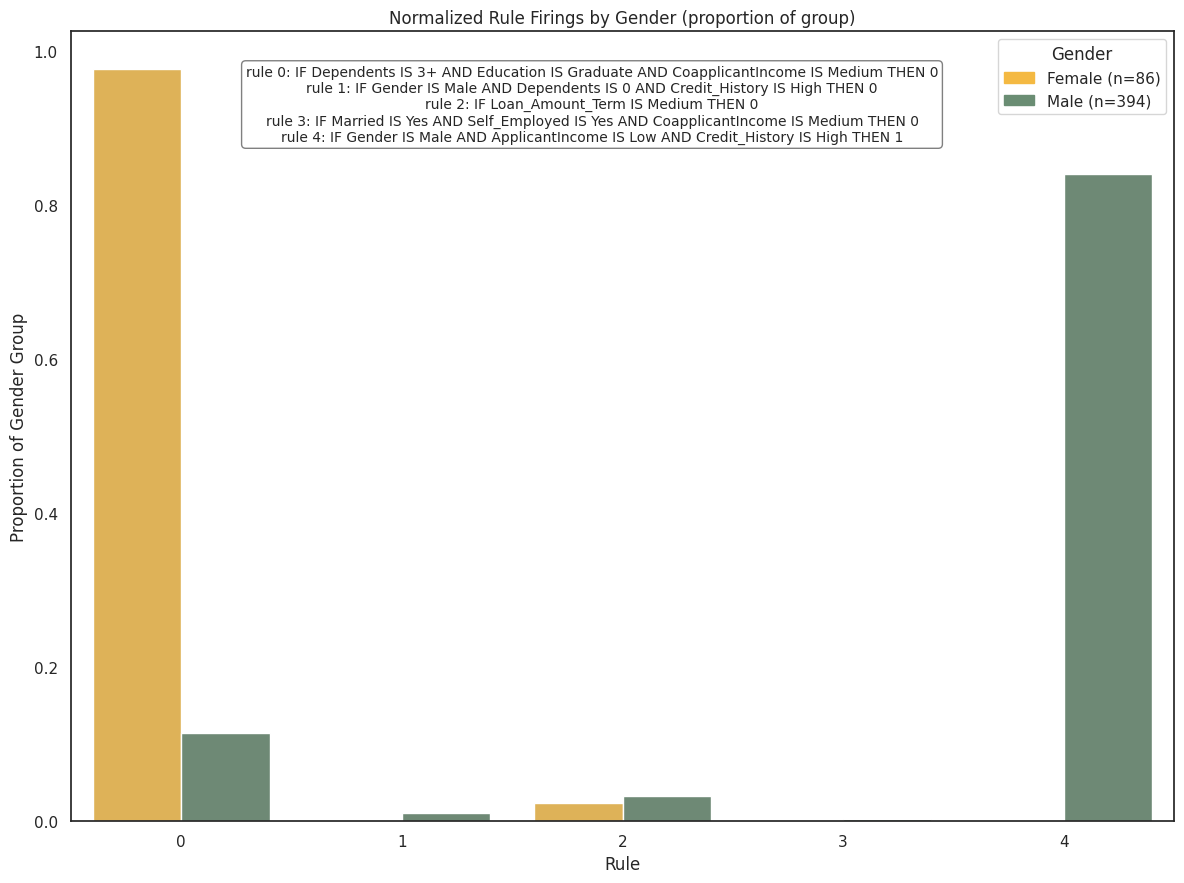

In [36]:
explainable_predict = fl_classifier.explainable_predict(X)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]
rule_collection = extract_rules_from_text(str_rules)
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X)
n_rules = rule_memberships.shape[1]  # Automatically detect number of rules

# Create a dictionary for the DataFrame
data = {
    'Gender': X['Gender'].values.ravel(),
    'rule_selected': np.array(fired_rules).ravel()  # Selected rule indices
}

# Add rule membership columns dynamically
for rule_idx in range(n_rules):
    data[f'rule {rule_idx}'] = rule_memberships[:, rule_idx].ravel()

# Create DataFrame
results = pd.DataFrame(data)
fig = plot_normalized_rule_firings_by_gender(results, rule_collection, figsize=(12, 10))

Podemos intentar definir pesos de forma distinta para controlar este sesgo, pero en este ejemplo vamos a continuar el tutorial con otro método.

### 5.3 Equidad mediante regularización (Fairness through regularization)

Otro método usado es considerar restricciones de equidad directamente en la función de pérdida del modelo, penalizando las disparidades entre grupos durante el entrenamiento. A diferencia de otros métodos post-hoc, éste actúa durante la optimización del modelo. Concretamente, en este caso consideramos la DPR con un parámetro de regularización $\lambda = 0.2$.

In [37]:
def new_loss2(ruleBase: rules.RuleBase, X:np.array, y:np.array, tolerance:float, alpha:float=0.99, beta:float=0.0125, gamma:float=0.0125, precomputed_truth=None) -> float:
        ev_object = evr.evalRuleBase(ruleBase, X, y, precomputed_truth=precomputed_truth)
        ev_object.add_rule_weights()
        preds = ev_object.mrule_base.winning_rule_predict(ev_object.X, precomputed_truth=ev_object.precomputed_truth)

        fairness_loss = demographic_parity_difference(y,preds,sensitive_features=A_train)
        return matthews_corrcoef(y, preds) - 0.2 * fairness_loss

categorical_mask = generar_mascara_categorica(X_train,verbose=False)
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fs.FUZZY_SETS.t1, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.001, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=3, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = False, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask = categorical_mask, # Máscara de variables categóricas.
                                           ds_mode=2, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )
fl_classifier.customized_loss(new_loss2)

fl_classifier.fit(X_train,
                  y_train,
                  n_gen=n_gen, # Número de iteraciones
                  pop_size=pop_size, # Número de individuos a considerar en cada iteración
                  random_state=42)

rule_base = fl_classifier.get_rulebase()

fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.8255451713395638
Test performance: 0.7987421383647799
------------
MATTHEW CORRCOEF
Train performance: 0.5804538080539554
Test performance: 0.4982237954520136
------------
Rules for consequent: 0
----------------
IF Dependents IS 0 AND Education IS Graduate WITH DS 0.044108655777797184, ACC 0.918918918918919, WGHT 0.26
IF Self_Employed IS No AND LoanAmount IS Low AND Loan_Amount_Term IS Medium WITH DS 0.006766590180397233, ACC 0.85, WGHT 0.07

Rules for consequent: 1
----------------
IF ApplicantIncome IS Medium WITH DS 0.006236437997822418, ACC 0.75, WGHT 0.88
IF ApplicantIncome IS Low AND Credit_History IS High WITH DS 0.4444345755477663, ACC 0.8115384615384615, WGHT 0.42



=== Model Evaluation Metrics ===
Accuracy:    0.7987
F1 Score:    0.8750
Recall:      1.0000

=== Confusion Matrix ===


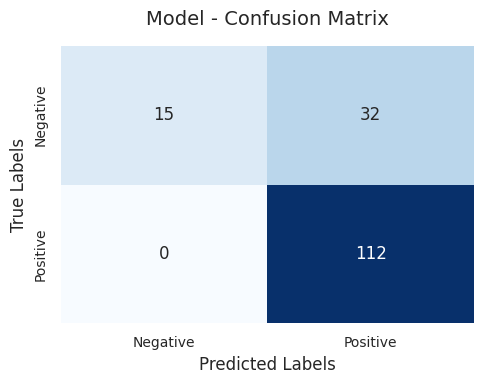

In [38]:
y_pred = fl_evaluator.fl_classifier.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

Al igual que antes, hacemos los cálculos para saber si el sesgo se ha controlado. Esta vez, parece que el método ha sido efectivo.

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'mcc'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>]], dtype=object)

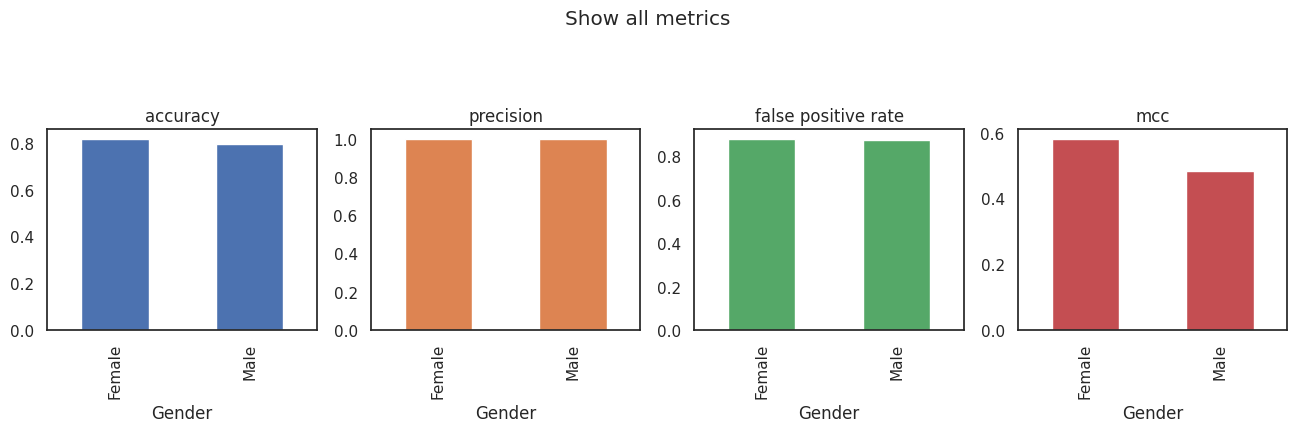

In [39]:
metrics = {"accuracy": accuracy_score,"precision": recall_score,"false positive rate": f1_score,"mcc": matthews_corrcoef}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[4, 4],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)

In [40]:
fairness_results, disparity_results = calculate_fairness_metrics(y_true=y_test,y_pred=y_pred,sensitive_features=A_test)


Disparity Metrics (Lower is Fairer for Differences, Closer to 1 is Fairer for Ratios):
Demographic Parity Difference    0.048772
Demographic Parity Ratio         0.946545
Equalized Odds Difference        0.128571
Equalized Odds Ratio             0.816327

Metrics by Group:
        Selection Rate  True Positive Rate  False Positive Rate  \
Gender                                                            
Female        0.863636                 1.0             0.571429   
Male          0.912409                 1.0             0.700000   

        False Negative Rate  True Negative Rate  
Gender                                           
Female                  0.0            0.428571  
Male                    0.0            0.300000  


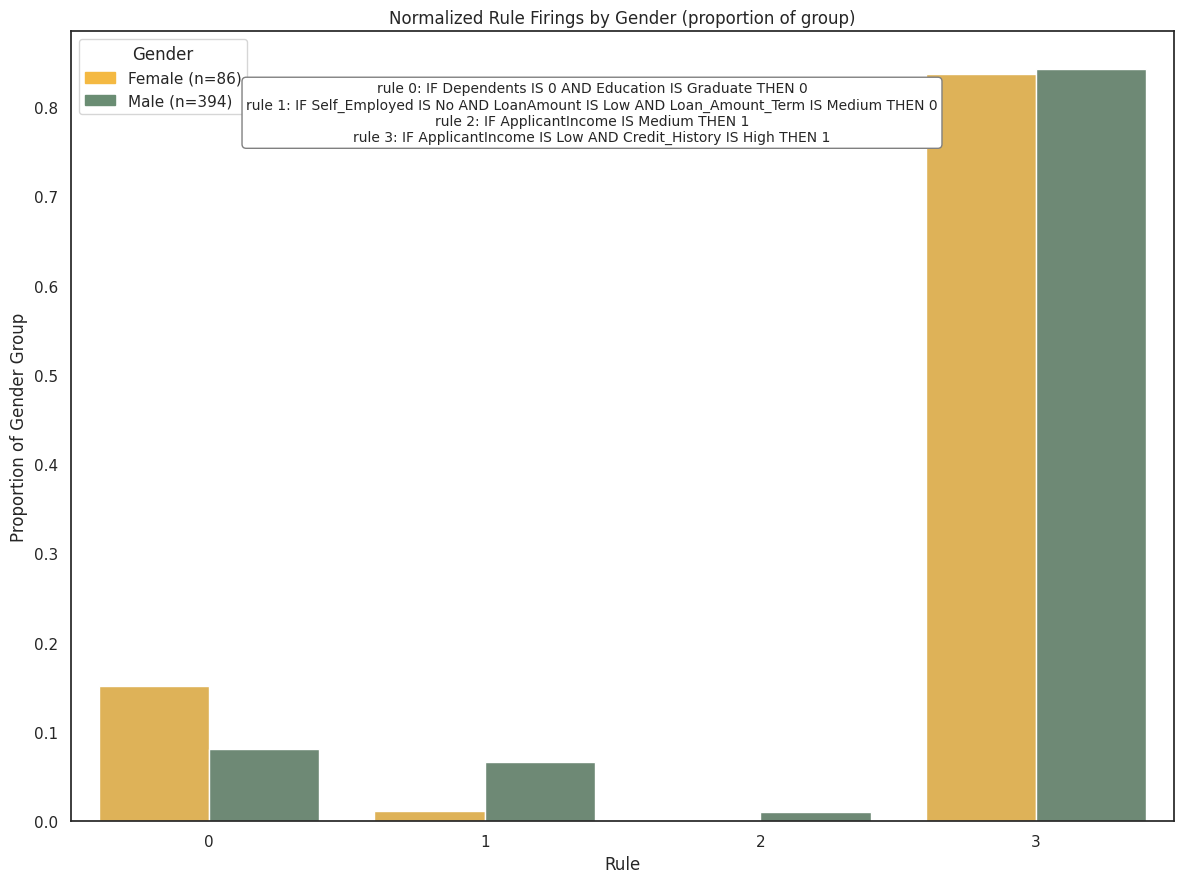

In [41]:
explainable_predict = fl_classifier.explainable_predict(X)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]
rule_collection = extract_rules_from_text(str_rules)
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X)
n_rules = rule_memberships.shape[1]  # Automatically detect number of rules

# Create a dictionary for the DataFrame
data = {
    'Gender': X['Gender'].values.ravel(),
    'rule_selected': np.array(fired_rules).ravel()  # Selected rule indices
}

# Add rule membership columns dynamically
for rule_idx in range(n_rules):
    data[f'rule {rule_idx}'] = rule_memberships[:, rule_idx].ravel()

# Create DataFrame
results = pd.DataFrame(data)
fig = plot_normalized_rule_firings_by_gender(results, rule_collection, figsize=(12, 10))

### References  
[1] F. Kamiran and T. Calders, *"Data preprocessing techniques for classification without discrimination,"* Knowledge and Information Systems, 2012. [DOI](https://doi.org/10.1007/s10115-011-0463-8)